# ValueInvestor
We are looking to establish a robust intelligent system that can aid investment activities, using past stock performance data. 

Our goal in this project is to use provided historical trading data to predict future stock price valuations on a daily, weekly, and monthly basis. We also provide recommendations on whether to BUY, HOLD or SELL each stock based on the predictions.

### Data Description


We are given trading data from 8 different countries in emerging markets that include the 2020 Q1-Q2-Q3-Q4 and 2021 Q1 stock prices. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. We will only 2020 data and predict with 2021 Q1 data.

Each set of data contain the following columns:
- `Date`
- `Price` (The closing price of the stock on a day)
- `Open` (The opening price of the stock on a day)
- `High` (The highest price of the stock on a day)
- `Low` (The lowest price of the stock on a day)
- `Vol.` (The volume/number of shares that were traded on a day)
- `Change %` (The percentage change from the closing price of the previous day)

### Data Loading
Let's first load the data of the first sheet.

In [530]:
# Import the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pandas.core.common import SettingWithCopyWarning
import warnings

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [531]:
df = pd.read_excel("2020Q1Q2Q3Q4-2021Q1.xlsx", sheet_name=None)

In [532]:
print(df.keys())

dict_keys(['Russia - Sberbank Rossii PAO (S', 'Turkey - Koc Holding AS (KCHOL)', 'Egypt - Medinet Nasr Housing (M', 'Brazil - Minerva SABrazil (BEEF', 'Argentina - Pampa Energia SA (P', 'Colombia - Cementos Argos SA (C', 'South Africa - Impala Platinum ', 'South Korea - Dongkuk Steel Mil'])


In [533]:
sheet1 = df[list(df.keys())[0]] # Extract the first sheet
sheet1 = sheet1.iloc[:-1,:] # Drop the last row
sheet1["Price"].describe(percentiles=[0.25, 0.5, 0.75])

count     311.0
unique    303.0
top       272.0
freq        2.0
Name: Price, dtype: float64

In [534]:
sheet1["Price"].astype(float).describe()

count    311.000000
mean     234.524019
std       32.079847
min      174.270000
25%      207.700000
50%      229.140000
75%      264.380000
max      293.300000
Name: Price, dtype: float64

In [535]:
sheet1["Change %"].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

### Data Exploration

#### Check for missing values

In [536]:
sheet1.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

#### Check for outliers

In [537]:
fig = px.box(sheet1, x="Price")
fig.show()

In [538]:
fig = px.box(sheet1, x="Open")
fig.show()

In [539]:
fig = px.box(sheet1, x="High")
fig.show()

In [540]:
fig = px.box(sheet1, x="Low")
fig.show()

In [541]:
sheet1['Vol.'].str[:-1].astype(float)

0      47.00
1      38.81
2      43.68
3      56.07
4      35.22
       ...  
306    18.85
307    38.33
308    40.82
309    22.35
310    35.85
Name: Vol., Length: 311, dtype: float64

In [542]:
sheet1['Vol.'] = sheet1['Vol.'].str[:-1].astype(float)
fig = px.box(sheet1, x='Vol.')
fig.show()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_2277/3553842436.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [543]:
sheet1['Vol.'].describe()

count    311.000000
mean      73.056977
std       38.058095
min        8.760000
25%       47.670000
50%       66.260000
75%       85.120000
max      263.040000
Name: Vol., dtype: float64

In [544]:
fig = px.box(sheet1, x="Change %")
fig.show()

In [545]:
sheet1['Change %'].describe()

count    311.000000
mean       0.000668
std        0.021931
min       -0.095700
25%       -0.010100
50%        0.000400
75%        0.012950
max        0.129000
Name: Change %, dtype: float64

Plot the price over time.

In [546]:
# Convert dates to DateTime
sheet1["Datetime"] = pd.to_datetime(sheet1["Date"],format='%Y-%m-%d %H:%M:%S') 

# Set Datetime as the index
sheet1 = sheet1.set_index(pd.DatetimeIndex(sheet1["Datetime"])).sort_index()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_2277/3080680778.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [547]:
fig = px.line(sheet1, x='Datetime', y="Price")
fig.show()

### ARIMA (Autoregressive integrated moving average)

#### Check assumptions of the ARIMA model
The following assumptions need to be satisified:
- Data should be stationary
- Data should be univariate

To check that the data is stationary, we can use the ADF (Augmented Dickey-Fuller) Test.

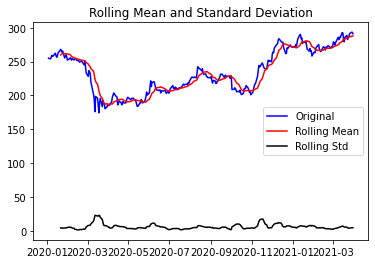

Results of dickey fuller test
Test Statistics                 -0.986360
p-value                          0.758207
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [548]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(sheet1.Price)

As the p-value > 0.05, we can't rule out the null hypothesis that a unit root exists in this sample.

<Figure size 432x288 with 0 Axes>

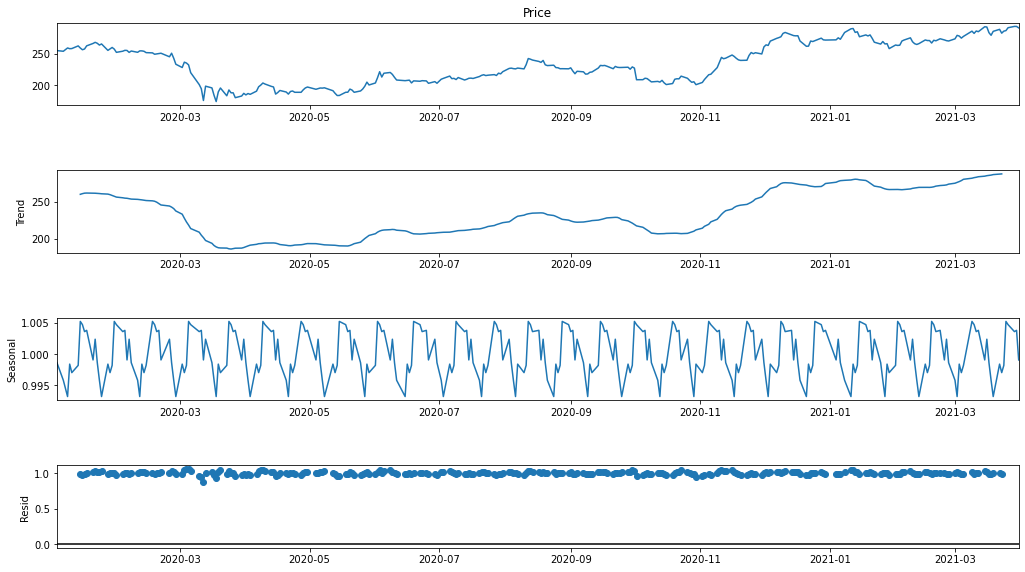

In [549]:
# Separate the trend and the seasonality from a time series
result = seasonal_decompose(sheet1.Price, period=12, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We can try and normalize the seasonality by the difference of log to price and shifted the log value of price to one step.

<AxesSubplot:title={'center':'after log transformed & differencing'}, xlabel='Datetime'>

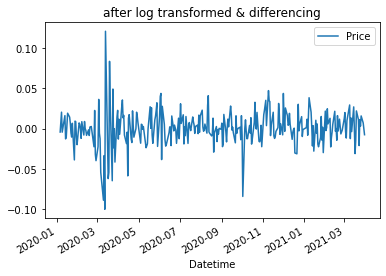

In [550]:
log_prices = pd.DataFrame(sheet1.Price.apply(lambda x : np.log(x)))
log_diff = log_prices - log_prices.shift()
#ax1 = plt.subplot()
log_diff.plot(title='after log transformed & differencing')
#ax2 = plt.subplot()
#sheet1.Price.plot(title='original'); 

Try the test for stationarity again.

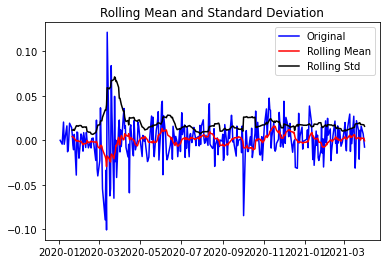

Results of dickey fuller test
Test Statistics               -5.905231e+00
p-value                        2.718502e-07
No. of lags used               7.000000e+00
Number of observations used    3.030000e+02
critical value (1%)           -3.452118e+00
critical value (5%)           -2.871127e+00
critical value (10%)          -2.571878e+00
dtype: float64


In [551]:
test_stationarity(log_diff.fillna(0))

Now the p-value is < 0.05.

Now lets split the data into training and testing data.
- We'll use data from 2020-01-01 to 2020-09-30 for training the model
- We'll use data from 2020-10-01 to 2020-12-31 for testing the model

In [552]:
train_data = log_diff[log_diff.index < datetime.strptime("2021-01-01", "%Y-%m-%d")]
test_data = log_diff[(log_diff.index >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (log_diff.index < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

In [553]:
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2020-10-01", "%Y-%m-%d")]
test_data = sheet1[(sheet1["Datetime"] >= datetime.strptime("2020-10-01", "%Y-%m-%d")) & (sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d"))]

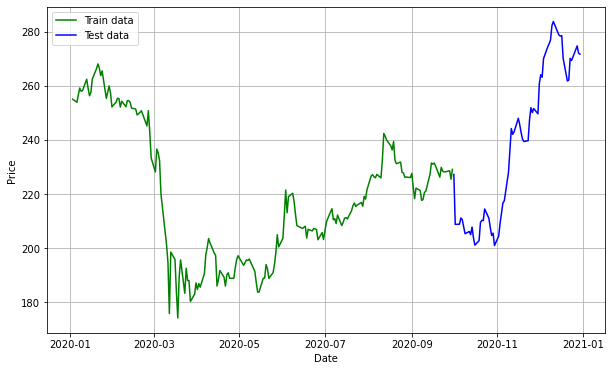

In [554]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(train_data["Datetime"], train_data["Price"], 'green', label='Train data')
plt.plot(test_data["Datetime"], test_data["Price"], 'blue', label='Test data')
plt.legend()

Using Auto ARIMA, we'll now choose the p, d and q values for our model, where:
- `p`: The auto-regressive part
- `d`: The integrated/differencing part - the amount of past time points to subtract from the current value
- `q`: The moving average part

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1117.175, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1119.022, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1119.000, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1115.325, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1121.174, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.168 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  186
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -556.663
Date:                Mon, 06 Feb 2023   AIC                           1115.325
Time:                        21:21:30   BIC                           1118.545
Sample:                             0   HQIC                          1116.630
                                - 186                                       

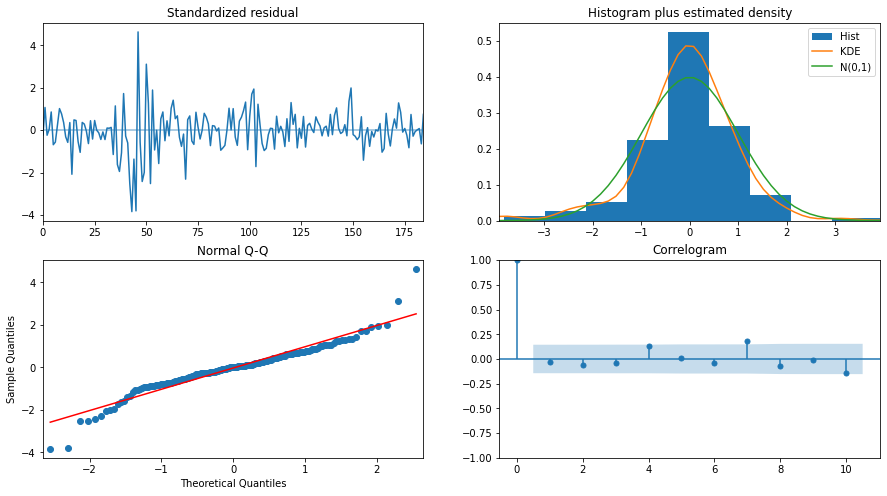

In [555]:
# Use Auto ARIMA to find the best p, d, and q values
model_autoARIMA = auto_arima(train_data.Price, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

We get the result, `Best model:  SARIMA(0,1,0)(0,0,0)[0]`, therefore the best parameters are p=0, d=1, q=0.

In [556]:
# Change train_data range
train_data = sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")]

In [557]:
# Build Model
#model = ARIMA(train_data.resample("D").last().Price, order=model_autoARIMA.order)
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,0])
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -756.924
Date:                Mon, 06 Feb 2023   AIC                           1515.847
Time:                        21:21:30   BIC                           1519.739
Sample:                    01-03-2020   HQIC                          1517.394
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        19.9952      0.982     20.368      0.000      18.071      21.919
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1000.99
Prob(Q):                              0.95   Pr

Let's do the same but with the SARIMAX model.

In [558]:
model_autoARIMA.order+(14,)

(0, 1, 0, 14)

In [559]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train_data.resample("D").last().Price, order=model_autoARIMA.order, seasonal_order=model_autoARIMA.order+(12,))
fitted_sarimax = model.fit()
print(fitted_sarimax.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59838D+00    |proj g|=  3.13513D-01

At iterate    5    f=  2.36266D+00    |proj g|=  7.84236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7      8      1     0     0   3.666D-07   2.363D+00
  F =   2.3626524882712236     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                           

 This problem is unconstrained.


Lets also created models with the following p, d and q values:
- [0,1,1]
- [0,1,2]
- [1,1,1]

In [560]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,1])
fitted2 = model.fit()  
print(fitted2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -755.534
Date:                Mon, 06 Feb 2023   AIC                           1515.067
Time:                        21:21:31   BIC                           1522.851
Sample:                    01-03-2020   HQIC                          1518.162
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1287      0.035     -3.705      0.000      -0.197      -0.061
sigma2        20.5150      1.086     18.883      0.000      18.386      22.644
Ljung-Box (L1) (Q):                   1.85   Jarque-

In [561]:
model = ARIMA(train_data.resample("D").last().Price, order=[0,1,2])
fitted3 = model.fit()  
print(fitted3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -754.658
Date:                Mon, 06 Feb 2023   AIC                           1515.317
Time:                        21:21:31   BIC                           1526.991
Sample:                    01-03-2020   HQIC                          1519.958
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0706      0.050     -1.409      0.159      -0.169       0.028
ma.L2         -0.0987      0.076     -1.291      0.197      -0.249       0.051
sigma2        20.3015      1.068     19.013      0.0

In [562]:
model = ARIMA(train_data.resample("D").last().Price, order=[1,1,1])
fitted4 = model.fit()  
print(fitted4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  363
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -755.273
Date:                Mon, 06 Feb 2023   AIC                           1516.545
Time:                        21:21:31   BIC                           1528.220
Sample:                    01-03-2020   HQIC                          1521.186
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2219      0.530      0.419      0.675      -0.816       1.260
ma.L1         -0.3382      0.492     -0.688      0.492      -1.302       0.626
sigma2        20.4892      1.085     18.893      0.0

##### SES (Simple Exponential Smoothing) Model

In [563]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

ses_model = SimpleExpSmoothing(np.asarray(train_data['Price']))

##### HES (Holt's Exponential Smoothing) Model

In [564]:
holt_model = Holt(np.asarray(train_data['Price']))

fit_holt = holt_model.fit(smoothing_level=.3, smoothing_trend=.05)

### Forecast on test dataset

##### ARIMA Model 1

In [565]:
predicted = fitted.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted.conf_int()
#predicted.predicted_mean

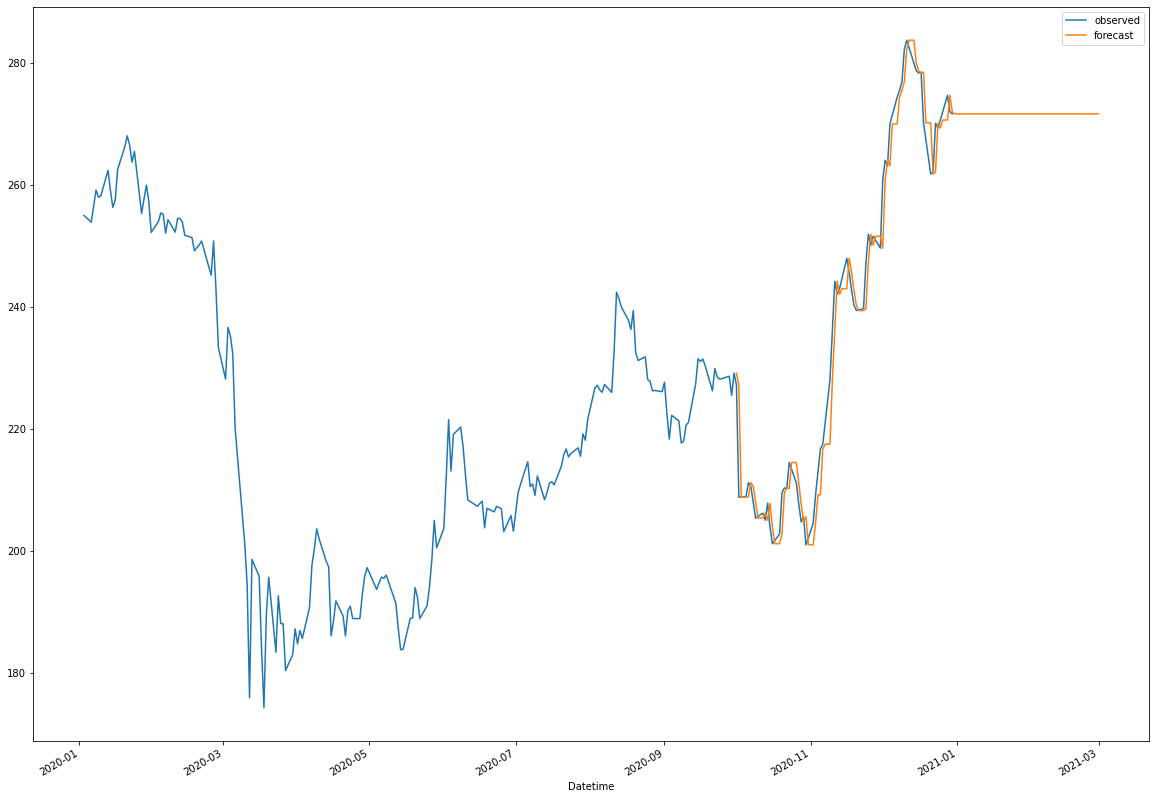

In [566]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### SARIMAX

In [567]:
predicted = fitted_sarimax.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-04-01"), dynamic=False, full_results=True)
predicted_ci = fitted_sarimax.conf_int()

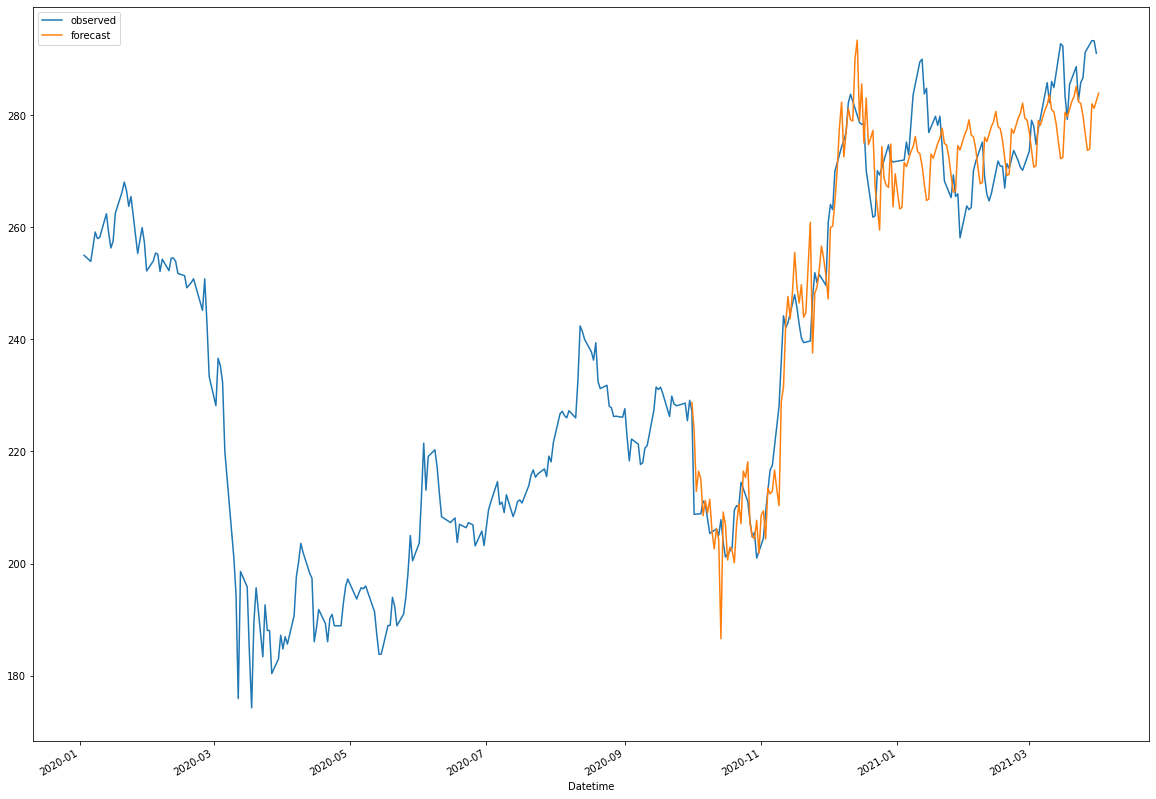

In [568]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-04-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

plt.legend()
plt.show()

##### ARIMA Model 2

In [569]:
predicted = fitted2.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted2.conf_int()
#predicted.predicted_mean

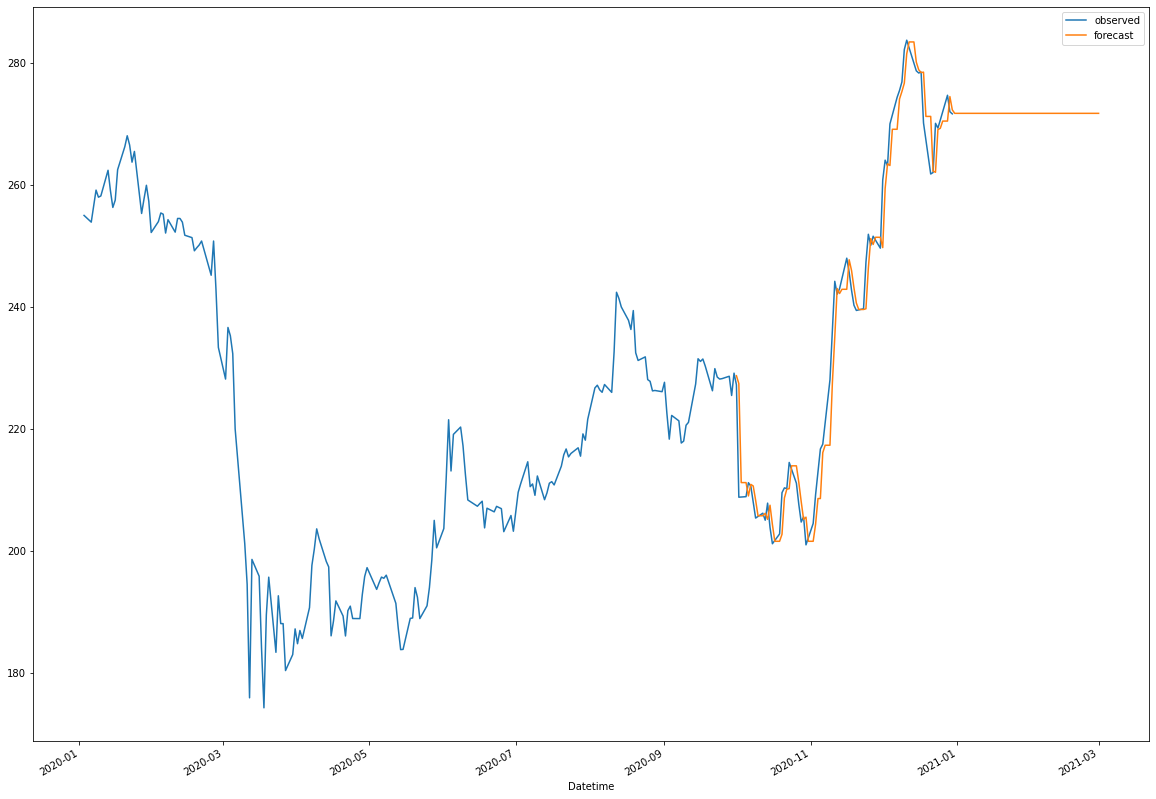

In [570]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 3

In [571]:
predicted = fitted3.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted3.conf_int()

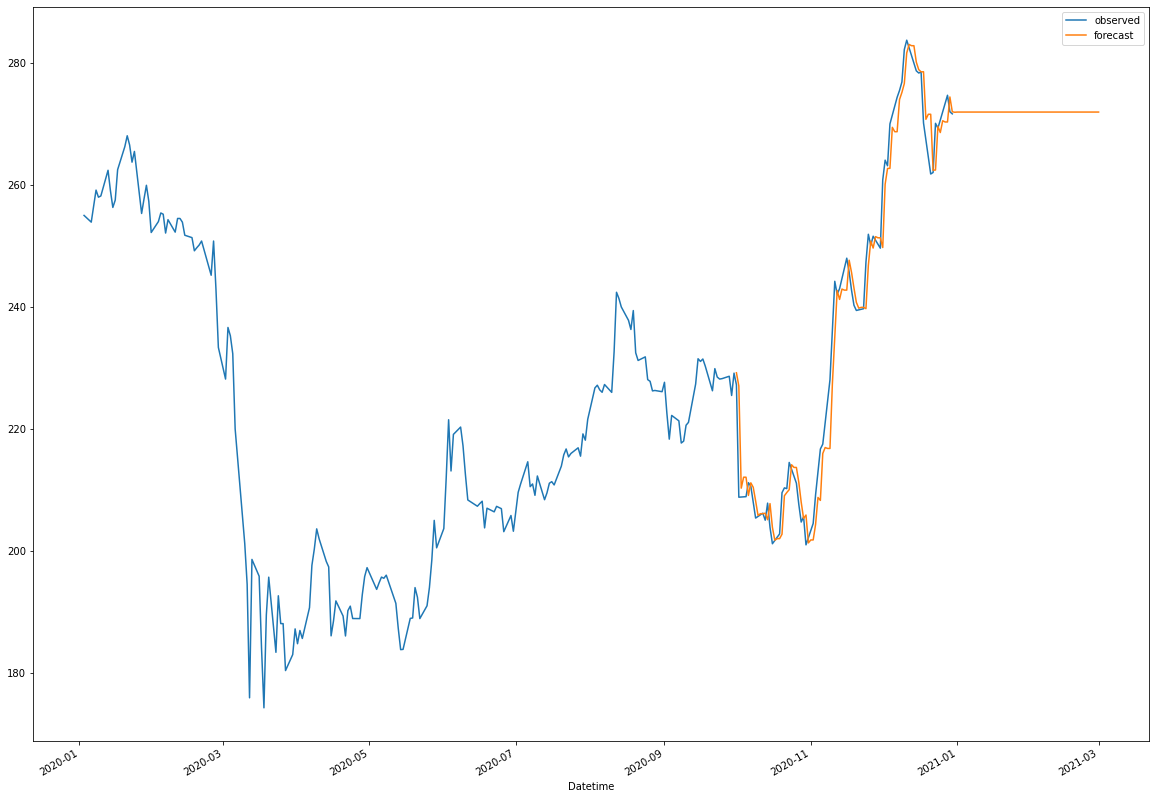

In [572]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

##### ARIMA Model 4

In [573]:
predicted = fitted4.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-03-01"), dynamic=False, full_results=True)
predicted_ci = fitted4.conf_int()

In [574]:
predicted.predicted_mean[0:10]

2020-10-01    228.834531
2020-10-02    227.348701
2020-10-03    210.982599
2020-10-04    211.466932
2020-10-05    211.574408
2020-10-06    209.067380
2020-10-07    210.978013
2020-10-08    210.599035
2020-10-09    208.275346
2020-10-10    205.784338
Freq: D, Name: predicted_mean, dtype: float64

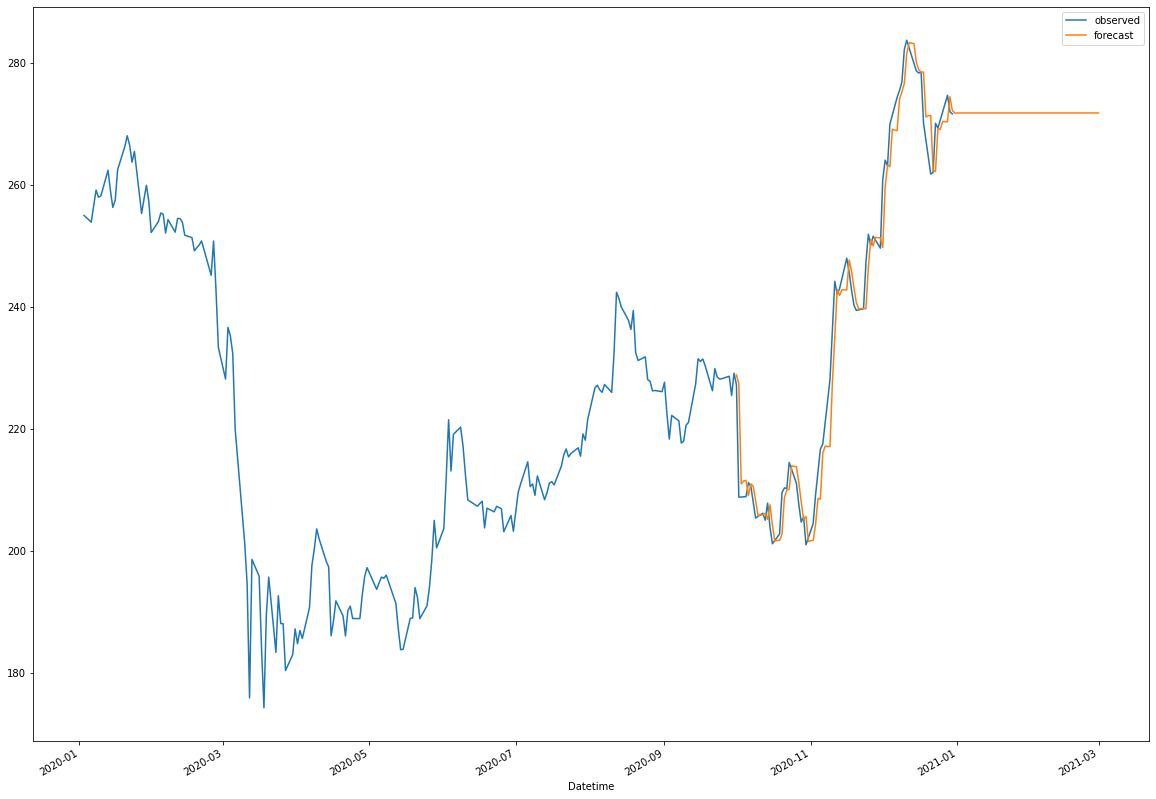

In [575]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

#ax.fill_between(predicted_ci.index, predicted_ci.iloc[:, 0], predicted_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

All of the ARIMA models have predictions that quickly (or immediately) converge to a single value.

##### SES (Simple Exponential Smoothing) Model

In [576]:
fit1 = ses_model.fit()
pred1 = fit1.forecast(9)
pred1

array([271.65000001, 271.65000001, 271.65000001, 271.65000001,
       271.65000001, 271.65000001, 271.65000001, 271.65000001,
       271.65000001])

With smoothing_level = 0.2

In [577]:
fit2 = ses_model.fit(smoothing_level=0.2)
pred2 = fit2.forecast(9)
pred2

array([271.33845345, 271.33845345, 271.33845345, 271.33845345,
       271.33845345, 271.33845345, 271.33845345, 271.33845345,
       271.33845345])

With smoothing_level = 0.5

In [578]:
fit3 = ses_model.fit(smoothing_level=0.5)
pred3 = fit3.forecast(9)
pred3

array([271.85594137, 271.85594137, 271.85594137, 271.85594137,
       271.85594137, 271.85594137, 271.85594137, 271.85594137,
       271.85594137])

Each of these models produce a constant value.

##### HES Model

In [579]:
#pred_holt = fit_holt.forecast(92)
pred_holt = fit_holt.forecast(152)

In [580]:
predictions_holt = pd.Series(pred_holt)
predictions_holt.index = predicted.predicted_mean.index

<AxesSubplot:xlabel='Datetime'>

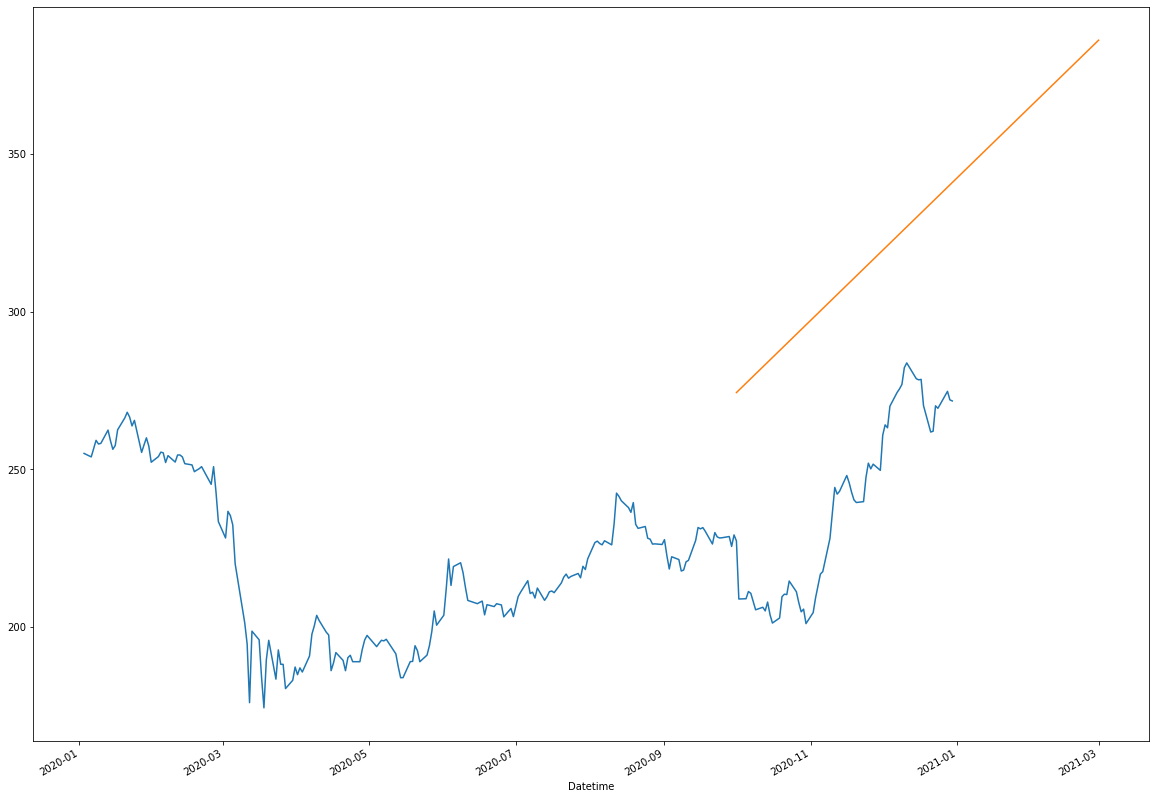

In [581]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predictions_holt.plot(ax=ax, label='forecast')

##### Simple Moving Average Model

In [582]:
y_hat_sma = sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price.copy()
ma_window = 90 # 3 months
y_hat_sma['Price'] = y_hat_sma.rolling(ma_window).mean()

(0.0, 289.20300000000003)

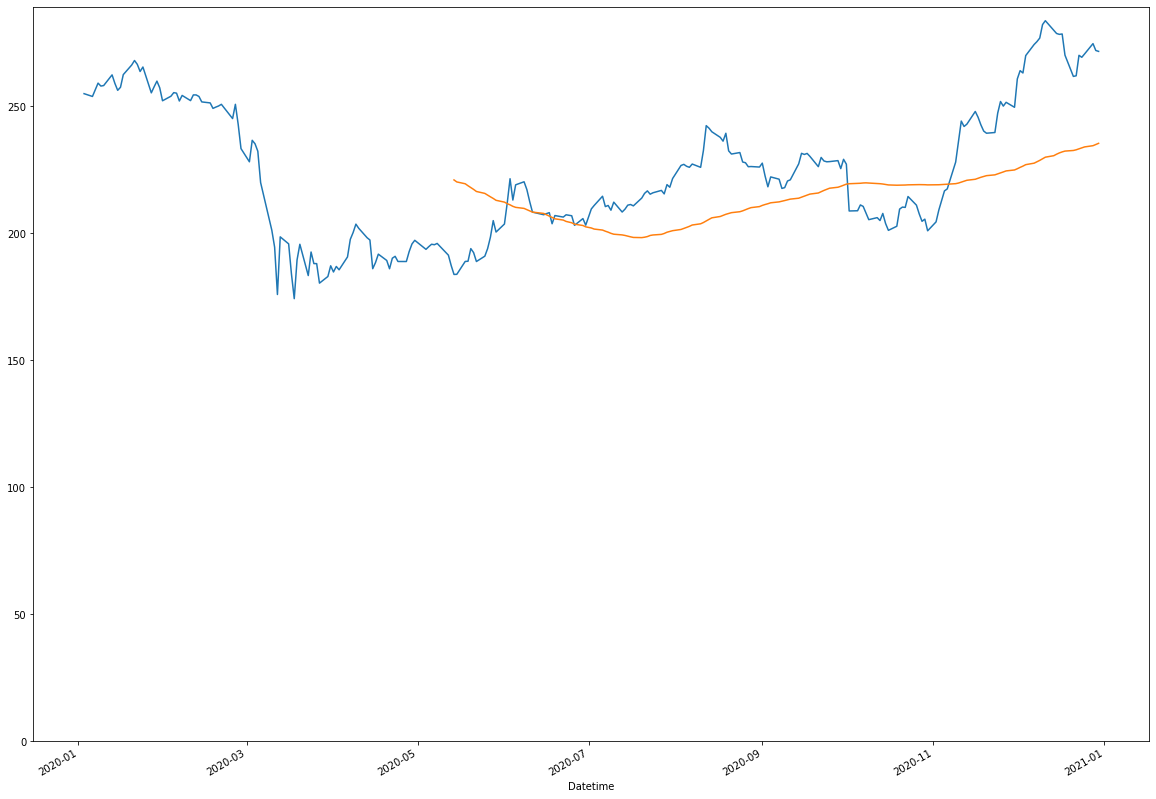

In [583]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
y_hat_sma.Price.plot(ax=ax, label='forecast')
ax.set_ylim(bottom=0)

### Forecast Future Unknown Data (2021 data)

Lets use the forecast from the SARIMAX model.

In [584]:
# TODO: SARIMAX predictions
predicted = fitted_sarimax.get_prediction(start=pd.to_datetime("2021-01-01"), end=pd.to_datetime("2021-04-01"), dynamic=False, full_results=True)
predicted_ci = fitted_sarimax.conf_int()

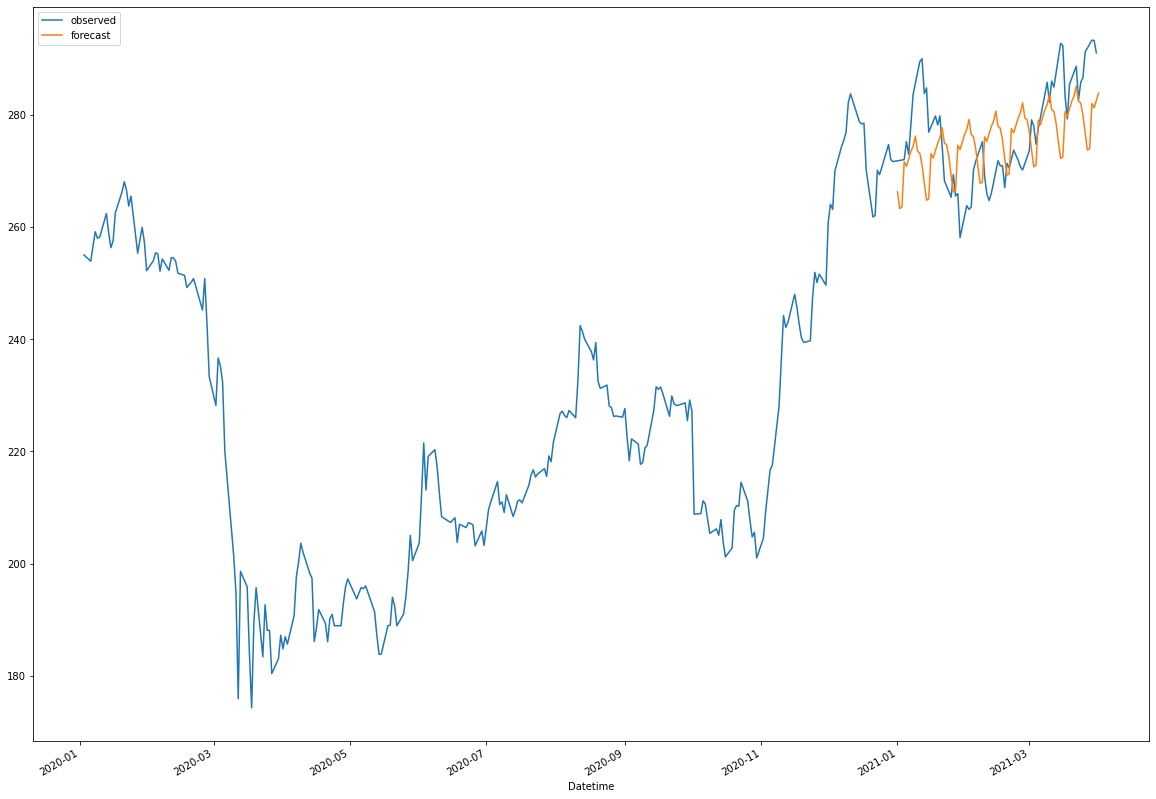

In [585]:
ax = (sheet1[sheet1["Datetime"] < datetime.strptime("2021-04-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
predicted.predicted_mean.plot(ax=ax, label='forecast')

plt.legend()
plt.show()

Lets add a column for the predicted price and the decision (to buy, sell or hold).

In [586]:
sheet1["Predicted Price"] = predicted.predicted_mean
sheet1["Decision"] = ""

Lets create a function to calculate the mean squared error between prices and predicted prices.

In [587]:
def calculate_error(df):
    return mean_squared_error(df["Price"], df["Predicted Price"])

In [588]:
# Calculate mse for SARIMAX model
print(f'MSE: {calculate_error(sheet1[sheet1.Datetime > "2020-12-31"])}')

# Calculate MAPE
print(f'MAPE: {mean_absolute_percentage_error(sheet1[sheet1.Datetime > "2020-12-31"]["Price"].to_numpy(), sheet1[sheet1.Datetime > "2020-12-31"]["Predicted Price"].to_numpy())}')

MSE: 85.25561848748923
MAPE: 0.02685529759533074


### Strategy 1: Buy/sell/hold based on tomorrow's price

We will make decisions according to the following rules:
- If Predicted Price tomorrow > Price today => BUY
- If Predicted Price tomorrow > Price today AND Decision yesterday == BUY => HOLD
- If Predicted Price tomorrow < Price today => SELL

In [589]:
def make_decision(price_today, price_tomorrow, decision_yesterday):
    if float(price_tomorrow) > float(price_today):
        if "BUY" in decision_yesterday:
            return "HOLD"
        return "BUY"
    return "SELL"

Lets mark whether we should buy or sell on each day.

In [590]:
def hold_period_expired(df, i, hold_period):
    # Get last {hold_period} number of decisions
    decisions = set(df.iloc[i-hold_period:i, df.columns.get_loc('Decision')])
    # If a decision that is not HOLD exists, return false
    if decisions != set(["HOLD"]):
        return False
    return True

In [591]:
def make_decisions(df, hold_period):
    stocks_held = False

    for i in range(len(df.index)-1):
        if not hold_period_expired(df, i, hold_period):
            decision = "HOLD"
        else:
            # Compare today's price with yesterday's predicted price
            price_today = df.iloc[i]["Price"]
            price_tomorrow = df.iloc[i+1]["Predicted Price"]
            decision_yesterday = df.iloc[i-1]["Decision"]

            # Make decision
            decision = make_decision(price_today, price_tomorrow, decision_yesterday)

        if decision == "SELL" and not stocks_held:
            decision = "HOLD"

        if decision == "BUY":
            if stocks_held or not hold_period_expired(df, i, hold_period):
                decision = "HOLD"
            else:
                stocks_held = True
            
        df.at[df.iloc[i].Datetime, "Decision"] = str(decision)

        # Set first day decision to "BUY"
        if i==0:
            df.at[df.iloc[i].Datetime, "Decision"] = "BUY"
            stocks_held = True

    return df

### Strategy 2

In [592]:
# Buy and sell at local minima and maxima
def make_decisions_2(df):
    stocks_held = False

    for i in range(len(df.index)-1):
        # Compare today's price with yesterday's predicted price
        price_today = df.iloc[i]["Predicted Price"]
        price_tomorrow = df.iloc[i+1]["Predicted Price"]

        # Set first day decision to "BUY"
        if i==0:
            decision = "BUY"
            stocks_held = True
        else:
            if price_tomorrow > price_today:
                # Price is increasing tomorrow
                if not stocks_held:
                    decision = "BUY"
                    stocks_held = True
                else:
                    decision = "HOLD"
            elif price_tomorrow < price_today:
                # Price is decreasing tomorrow
                if stocks_held:
                    decision = "SELL"
                    stocks_held = False
                else:
                    decision = "HOLD"
            else:
                decision = "HOLD"
                
        df.at[df.iloc[i].Datetime, "Decision"] = str(decision)


        

    return df

In [593]:
sheet1_predictions_sarimax = make_decisions_2(sheet1[sheet1["Datetime"] > "2020-12-31"])

In [594]:
fig = px.line(predicted.predicted_mean)
fig.show()

### Strategy 3: Use prior data available
Here we look at the past 20 days's prices for the stock and make a decision based on the mean and standard deviation.

In [595]:
i=42
df_temp = sheet1[sheet1["Datetime"] > "2020-10-31"]
model = ARIMA(df_temp.iloc[i-20:i].resample("D").last()["Price"], order=[0,1,0])
fitted = model.fit()
predicted_price = fitted.get_prediction(start=df_temp.iloc[i]['Datetime'], end=df_temp.iloc[i]['Datetime']).predicted_mean
predicted_price[0]

271.65

In [596]:
list(sheet1.iloc[0:250-1]["Price"].values)

[255.0,
 253.9,
 259.15,
 257.99,
 258.19,
 262.4,
 259.05,
 256.31,
 257.51,
 262.5,
 266.28,
 268.06,
 266.54,
 263.73,
 265.49,
 255.32,
 257.7,
 259.94,
 257.31,
 252.2,
 253.99,
 255.4,
 255.2,
 252.11,
 254.3,
 252.26,
 254.5,
 254.5,
 253.89,
 251.75,
 251.36,
 249.2,
 249.7,
 250.15,
 250.8,
 245.19,
 250.8,
 242.88,
 233.36,
 228.17,
 236.63,
 235.27,
 232.33,
 219.99,
 201.2,
 194.53,
 175.91,
 198.6,
 195.85,
 184.01,
 174.27,
 189.51,
 195.69,
 183.37,
 192.64,
 188.08,
 188.07,
 180.38,
 183.0,
 187.21,
 184.78,
 186.95,
 185.64,
 190.7,
 197.63,
 200.29,
 203.61,
 201.99,
 198.26,
 197.37,
 186.07,
 188.5,
 191.8,
 189.32,
 186.05,
 190.2,
 190.94,
 188.91,
 188.9,
 192.8,
 195.8,
 197.25,
 193.69,
 194.75,
 195.7,
 195.51,
 196.02,
 191.4,
 187.31,
 183.81,
 183.85,
 188.93,
 189.0,
 193.98,
 192.4,
 188.9,
 191.0,
 194.0,
 198.51,
 205.0,
 200.5,
 203.66,
 212.0,
 221.5,
 213.1,
 219.1,
 220.3,
 217.23,
 212.53,
 208.35,
 207.32,
 207.76,
 208.14,
 203.77,
 207.0,
 206.

In [634]:
def make_decisions_3(df, model_parameters=[0, 0, 0], arimax=False):
    stocks_held = False

    first_day_of_year = df.index.get_loc("2021-01-04")

    for i in range(first_day_of_year,len(df.index)):
        price = df.iloc[i]["Price"]

        # Create model and forecast next price
        #rolling_mean_volume = df.iloc[i-5:i]["Vol."].mean()
        train_exog = list(df.iloc[0:i-1]["Vol."].values)
        #print(train_exog)
        model = ARIMA(list(df.iloc[0:i-1]["Price"].values), order=model_parameters) if arimax is False else ARIMA(list(df.iloc[0:i-1]["Price"].values), order=model_parameters, exog=train_exog)
        fitted = model.fit()
        predicted_price = fitted.forecast(steps=1)[0] if arimax is False else fitted.forecast(steps=1, exog=train_exog[i-2])[0]
        df.at[df.iloc[i].Datetime, "Predicted Price"] = predicted_price

        # Calculate mean and standard deviation for 20 days prior
        previous = df.iloc[i-20:i]["Price"]
        mean = previous.mean()
        std = previous.std()

        # Make decision based on mean and standard deviation
        if (predicted_price <= (mean - 2*std)) and (stocks_held is False):
            decision = "BUY"
            stocks_held = True
        elif (predicted_price >= (mean + 2*std)) and (stocks_held is True):
            decision = "SELL"
            stocks_held = False
        else:
            decision = "HOLD"

        if i == first_day_of_year:
            decision = "BUY"
            stocks_held = True
        df.at[df.iloc[i].Datetime, "Decision"] = str(decision)
         

    # Return df from starting date
    return df[df["Datetime"] > "2020-12-31"]

In [787]:
results = pd.DataFrame(list(df.keys()))
results = results.set_index([0])

model_dict = {
    'ARIMA':[(0,1,0), (0,1,1), (0,1,2)], 
    'MA':[(0,0,1),(0,0,2),(0,0,3),(0,0,4),(0,0,5),(0,0,6)], 
    'ARIMAX':[(0,1,0), (0,1,1), (0,1,2)]
}

for i in range(0,len(list(df.keys()))):
    sheet = df[list(df.keys())[i]]
    sheet = sheet.iloc[:-1,:] # Drop the last row
    sheet["Predicted Price"] = predicted.predicted_mean
    sheet["Decision"] = ""
    sheet['Vol.'] = sheet['Vol.'].str[:-1].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

    # Convert dates to DateTime
    sheet["Datetime"] = pd.to_datetime(sheet["Date"],format='%Y-%m-%d %H:%M:%S') 

    # Set Datetime as the index
    sheet = sheet.set_index(pd.DatetimeIndex(sheet["Datetime"])).sort_index()

    # Run ARIMA models
    for parameter_set in model_dict['ARIMA']:
        sheet_predictions = make_decisions_3(sheet, parameter_set)
        profit = calculate_profit(sheet_predictions, 100e3)
        results.at[list(df.keys())[i], "ARIMA" + str(parameter_set)]= profit

    # Run MA models
    for parameter_set in model_dict['MA']:
        sheet_predictions = make_decisions_3(sheet, parameter_set)
        profit = calculate_profit(sheet_predictions, 100e3)
        results.at[list(df.keys())[i], "MA" + str(parameter_set)]= profit

    # Run ARIMAX models
    for parameter_set in model_dict['ARIMAX']:
        sheet_predictions = make_decisions_3(sheet, parameter_set, arimax=True)
        profit = calculate_profit(sheet_predictions, 100e3)
        results.at[list(df.keys())[i], "ARIMAX" + str(parameter_set)]= profit

results = results.T

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/s

In [788]:
results

,Russia - Sberbank Rossii PAO (S,Turkey - Koc Holding AS (KCHOL),Egypt - Medinet Nasr Housing (M,Brazil - Minerva SABrazil (BEEF,Argentina - Pampa Energia SA (P,Colombia - Cementos Argos SA (C,South Africa - Impala Platinum,South Korea - Dongkuk Steel Mil
"ARIMA(0, 1, 0)",1012.0,-8018.5,-5090.15,-6274.8,-2477.6,-18400.0,-5965.0,22880.0
"ARIMA(0, 1, 1)",1012.0,-8018.5,463.82,-6274.8,5607.2,-18400.0,-5965.0,20560.0
"ARIMA(0, 1, 2)",1012.0,-8018.5,463.82,-6274.8,5607.2,-18400.0,-5965.0,20560.0
"MA(0, 0, 1)",7916.0,-8018.5,-5090.15,-1992.0,12274.4,-18400.0,34490.0,63800.0
"MA(0, 0, 2)",7916.0,-8018.5,-5090.15,-3486.0,12274.4,-18400.0,34490.0,63800.0
"MA(0, 0, 3)",7916.0,-8018.5,-5090.15,-1992.0,12274.4,-18400.0,34490.0,63800.0
"MA(0, 0, 4)",4397.0,-8018.5,-5090.15,-6872.4,12274.4,-13300.0,34490.0,25370.0
"MA(0, 0, 5)",5152.0,-8018.5,-2870.80,-5278.8,18645.8,-13300.0,34490.0,17040.0
"MA(0, 0, 6)",2024.0,-8018.5,-5090.15,298.8,12274.4,-13300.0,7592.0,63800.0
"ARIMAX(0, 1, 0)",1012.0,-8018.5,-5090.15,-6274.8,-2477.6,-18400.0,-5965.0,22880.0


In [794]:
results = pd.DataFrame(list(df.keys()))
results = results.set_index([0])

model_dict = {
    'ARIMA':[(0,1,0), (0,1,1), (0,1,2)], 
    'MA':[(0,0,1),(0,0,2),(0,0,3),(0,0,4),(0,0,5),(0,0,6)], 
    'ARIMAX':[(0,1,0), (0,1,1), (0,1,2)]
}

for i in range(0,len(list(df.keys()))):
    if i == 1:
        sheet = df[list(df.keys())[i]]
        sheet = sheet.iloc[:-1,:] # Drop the last row
        sheet["Predicted Price"] = predicted.predicted_mean
        sheet["Decision"] = ""
        sheet['Vol.'] = sheet['Vol.'].str[:-1].apply(pd.to_numeric, errors='coerce').fillna(0, downcast='infer')

        # Convert dates to DateTime
        sheet["Datetime"] = pd.to_datetime(sheet["Date"],format='%Y-%m-%d %H:%M:%S') 

        # Set Datetime as the index
        sheet = sheet.set_index(pd.DatetimeIndex(sheet["Datetime"])).sort_index()

        # Run ARIMA models
        for parameter_set in model_dict['ARIMA']:
            sheet_predictions = make_decisions_3(sheet, parameter_set)
            profit = calculate_profit(sheet_predictions, 100e3)
            results.at[list(df.keys())[i], "ARIMA" + str(parameter_set)]= profit

        # Run MA models
        for parameter_set in model_dict['MA']:
            sheet_predictions = make_decisions_3(sheet, parameter_set)
            profit = calculate_profit(sheet_predictions, 100e3)
            results.at[list(df.keys())[i], "MA" + str(parameter_set)]= profit

        # Run ARIMAX models
        for parameter_set in model_dict['ARIMAX']:
            sheet_predictions = make_decisions_3(sheet, parameter_set, arimax=True)
            profit = calculate_profit(sheet_predictions, 100e3)
            results.at[list(df.keys())[i], "ARIMAX" + str(parameter_set)]= profit

results = results.T

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/s

In [795]:
results

,Russia - Sberbank Rossii PAO (S,Turkey - Koc Holding AS (KCHOL),Egypt - Medinet Nasr Housing (M,Brazil - Minerva SABrazil (BEEF,Argentina - Pampa Energia SA (P,Colombia - Cementos Argos SA (C,South Africa - Impala Platinum,South Korea - Dongkuk Steel Mil
"ARIMA(0, 1, 0)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"ARIMA(0, 1, 1)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"ARIMA(0, 1, 2)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"MA(0, 0, 1)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"MA(0, 0, 2)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"MA(0, 0, 3)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"MA(0, 0, 4)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"MA(0, 0, 5)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"MA(0, 0, 6)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN
"ARIMAX(0, 1, 0)",NaN,-8018.5,NaN,NaN,NaN,NaN,NaN,NaN


In [789]:
results.to_csv('results.csv')

In [679]:
# Calculate mse
print(f'MSE: {calculate_error(sheet1_predictions[sheet1_predictions.Datetime > "2020-12-31"])}')

# Calculate MAPE
print(f'MAPE: {mean_absolute_percentage_error(sheet1_predictions[sheet1_predictions.Datetime > "2020-12-31"]["Price"].to_numpy(), sheet1_predictions[sheet1_predictions.Datetime > "2020-12-31"]["Predicted Price"].to_numpy())}')

NameError: name 'sheet1_predictions' is not defined

### Weekly and Monthly Predictions

In [372]:
def weekly_predictions(df):
    df["day"] = df.index.weekday
    # Return predicted price on Friday
    return df[df["day"] == 4]["Predicted Price"]

def monthly_predictions(df):
    return df.groupby(pd.DatetimeIndex(df.Datetime).to_period('M')).nth(0)["Predicted Price"]

In [373]:
monthly_predictions(sheet1_predictions)

Datetime
2021-01    273.1855
2021-02    275.2505
2021-03    269.1005
Freq: M, Name: Predicted Price, dtype: float64

In [374]:
weekly_predictions(sheet1_predictions)

Datetime
2021-01-08    273.8170
2021-01-15    275.4885
2021-01-22    276.5675
2021-01-29    275.9450
2021-02-05    273.6910
2021-02-12    269.4305
2021-02-19    267.3065
2021-02-26    268.4975
2021-03-05    271.3430
2021-03-12    273.8305
2021-03-19    278.2450
2021-03-26    281.9810
Name: Predicted Price, dtype: float64

### Calculate Total Profit

Lets now calculate our total profit.

In [206]:
def calculate_profit(df, capital):
    starting_capital = capital
    num_stocks = 0
    
    for i in range(len(df.index)-1):
        current_decision = df.iloc[i].Decision

        # Perform calculation for BUY/SELL
        if current_decision == "BUY":
            num_stocks += round(capital/df.iloc[i].Price)
            capital -= round(capital/df.iloc[i].Price)*df.iloc[i].Price
        elif current_decision == "SELL":
            capital += num_stocks * df.iloc[i].Price
            num_stocks = 0
    
    if num_stocks == 0:
        return capital - starting_capital
    else:
        return num_stocks * df.iloc[i].Price - starting_capital

### Bollinger Bands
Use Bollinger Bands to measure your systems effectiveness.

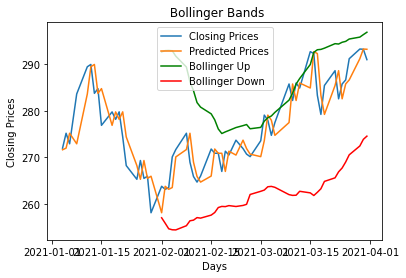

In [758]:
import pandas_datareader as pdr

def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=20):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return bollinger_up, bollinger_down

closing_prices = sheet1_predictions['Price']

bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

# New strategy
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(sheet1_predictions['Predicted Price'], label='Predicted Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()

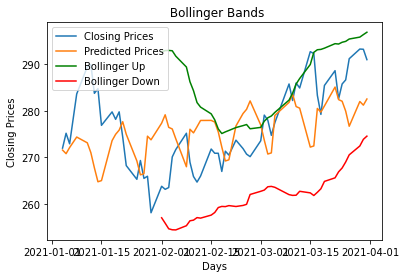

In [759]:
# SARIMAX model strategy
plt.title(' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(closing_prices, label='Closing Prices')
plt.plot(sheet1_predictions_sarimax['Predicted Price'], label='Predicted Prices')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()

### Apply AUTO ARIMA to remaining data sheets

Lets first plot each dataset (and apply any necessary preprocessing)

In [ ]:
sheets = []

for key in df.keys():
    sheet = df[key]
    
    # Drop the last row
    sheet = sheet.iloc[:-1,:] 

    # Convert dates to DateTime
    sheet["Datetime"] = pd.to_datetime(sheet["Date"],format='%Y-%m-%d %H:%M:%S') 

    # Set Datetime as the index
    sheet = sheet.set_index(pd.DatetimeIndex(sheet["Datetime"])).sort_index()

    sheets.append(sheet)

    fig = px.line(sheet, x='Datetime', y="Price", title=str(key))
    fig.show()

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/184476813.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Let's repeat this now, but instead use the SARIMAX model.

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3098.393, Time=0.13 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3096.536, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3096.551, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3100.371, Time=0.05 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3094.802, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.721 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1551.185
Date:                Wed, 28 Dec 2022   AIC                          -3100.371
Time:                        19:40:08   BIC                          -3096.853
Sample:                             0   HQIC                         -3098.955
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.263e-07   9.53e-09     23.732      0.000    2.08e-07

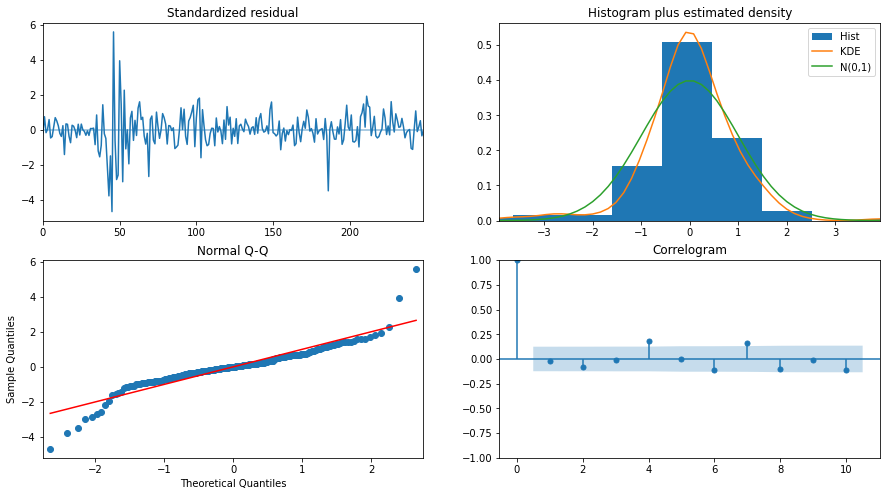

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.43866D+00    |proj g|=  2.74557D+03

At iterate    5    f= -3.65366D+00    |proj g|=  1.86638D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      9     79      2     0     0   1.624D+01  -3.654D+00
  F =  -3.6536566027031001     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                     SARIMAX Results                                      
Dep. Variable:                      Price

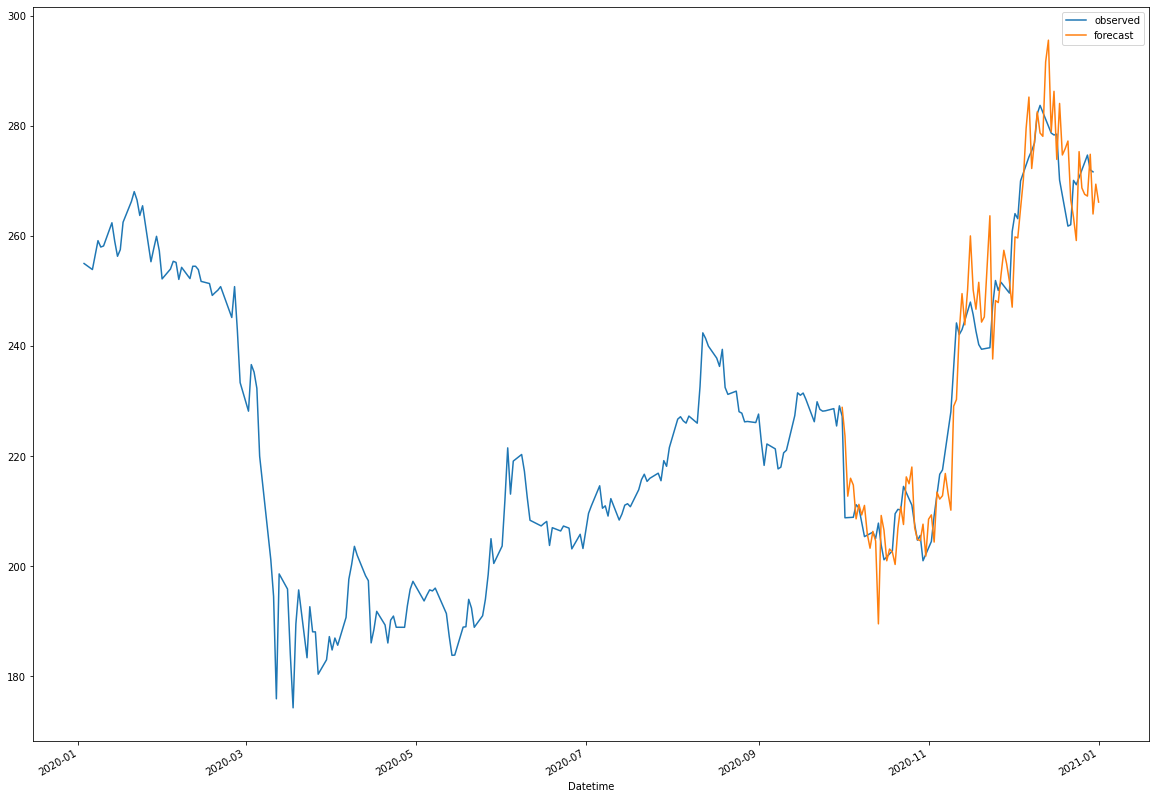

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2106.750, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2105.563, Time=0.12 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2105.626, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2108.743, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2102.749, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.431 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1055.371
Date:                Wed, 28 Dec 2022   AIC                          -2108.743
Time:                        19:40:09   BIC                          -2105.217
Sample:                             0   HQIC                         -2107.324
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



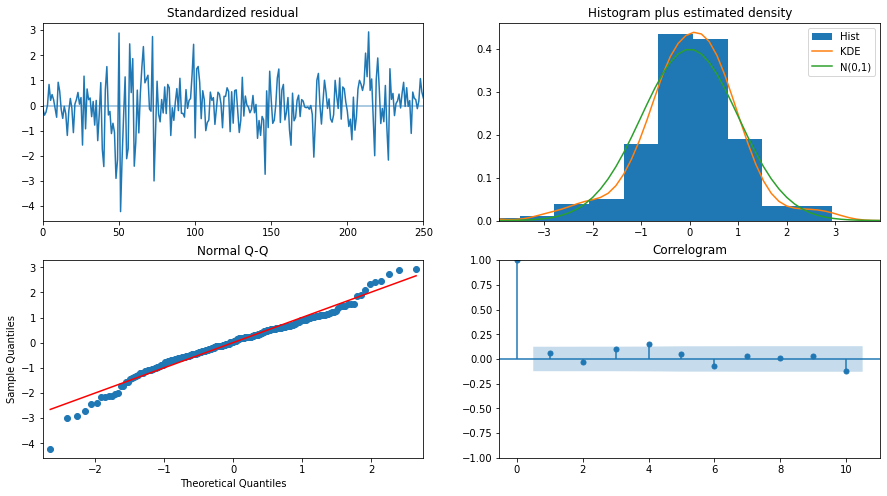

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.10349D+00    |proj g|=  5.03524D+02

At iterate    5    f= -2.38555D+00    |proj g|=  3.13585D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      6     34      1     0     0   3.136D-01  -2.386D+00
  F =  -2.3855493758429143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                      Price

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


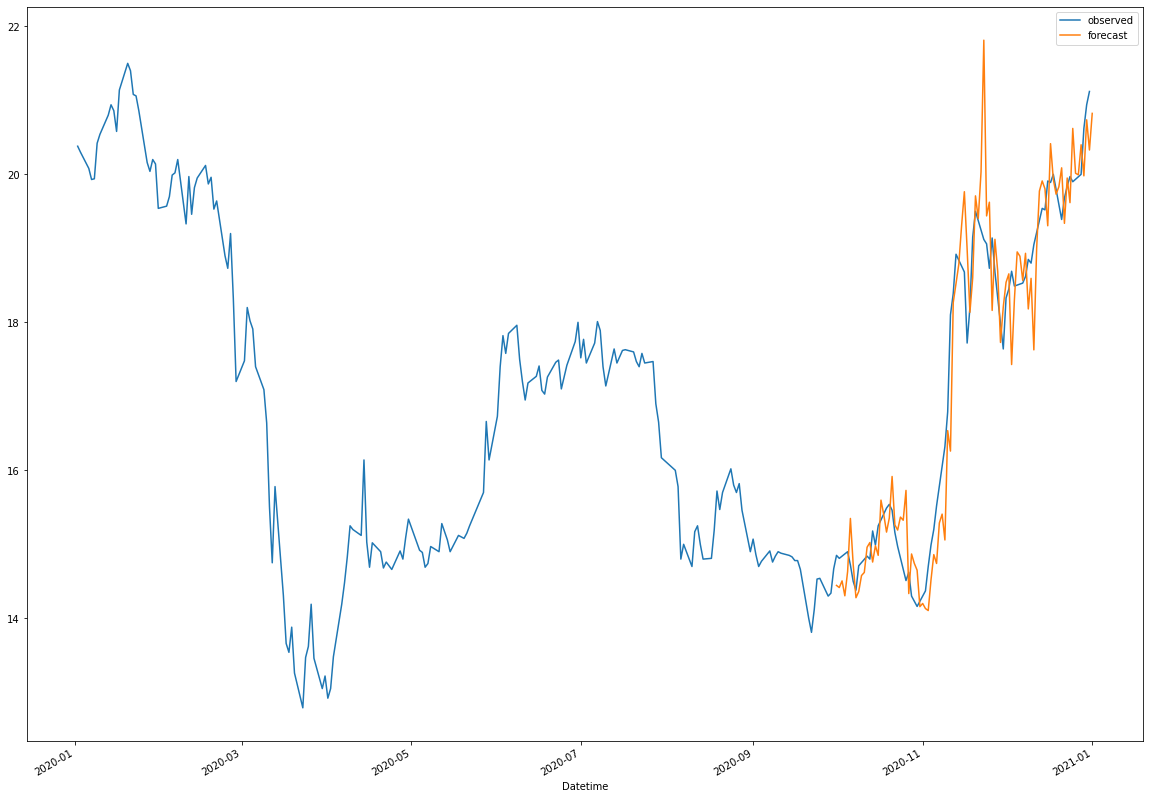

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1520.224, Time=0.06 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1535.378, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1533.601, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1522.025, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1533.416, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1533.354, Time=0.09 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1531.471, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1537.231, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-1535.254, Time=0.08 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1535.208, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1535.320, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-1533.327, Time=0.10 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.274 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 770.615
Date:                Wed, 28 Dec 2022   AIC                          -1537.231
Time:                        19:40:11   BIC                          -1530.253
Sample:                             0   HQIC                         -1534.420
                                - 243                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

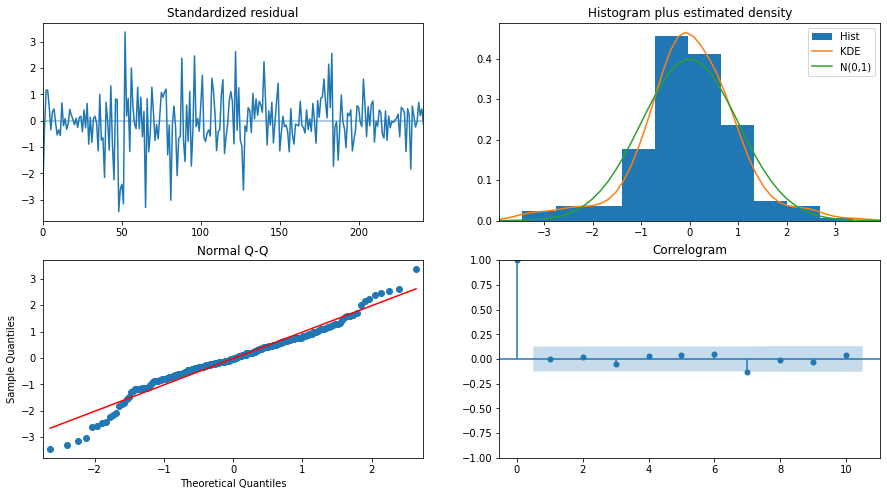

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.58436D+00    |proj g|=  1.48593D+01

At iterate    5    f= -1.60841D+00    |proj g|=  6.16313D-01

At iterate   10    f= -1.63161D+00    |proj g|=  2.26114D+01

At iterate   15    f= -1.71888D+00    |proj g|=  1.91881D-01


 This problem is unconstrained.



At iterate   20    f= -1.71967D+00    |proj g|=  2.88163D+00

At iterate   25    f= -1.72072D+00    |proj g|=  4.25630D-01

At iterate   30    f= -1.72230D+00    |proj g|=  9.65872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     50      1     0     0   5.920D-02  -1.722D+00
  F =  -1.7223003505950738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                      Price_box_cox   No. Observations:                  365
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log

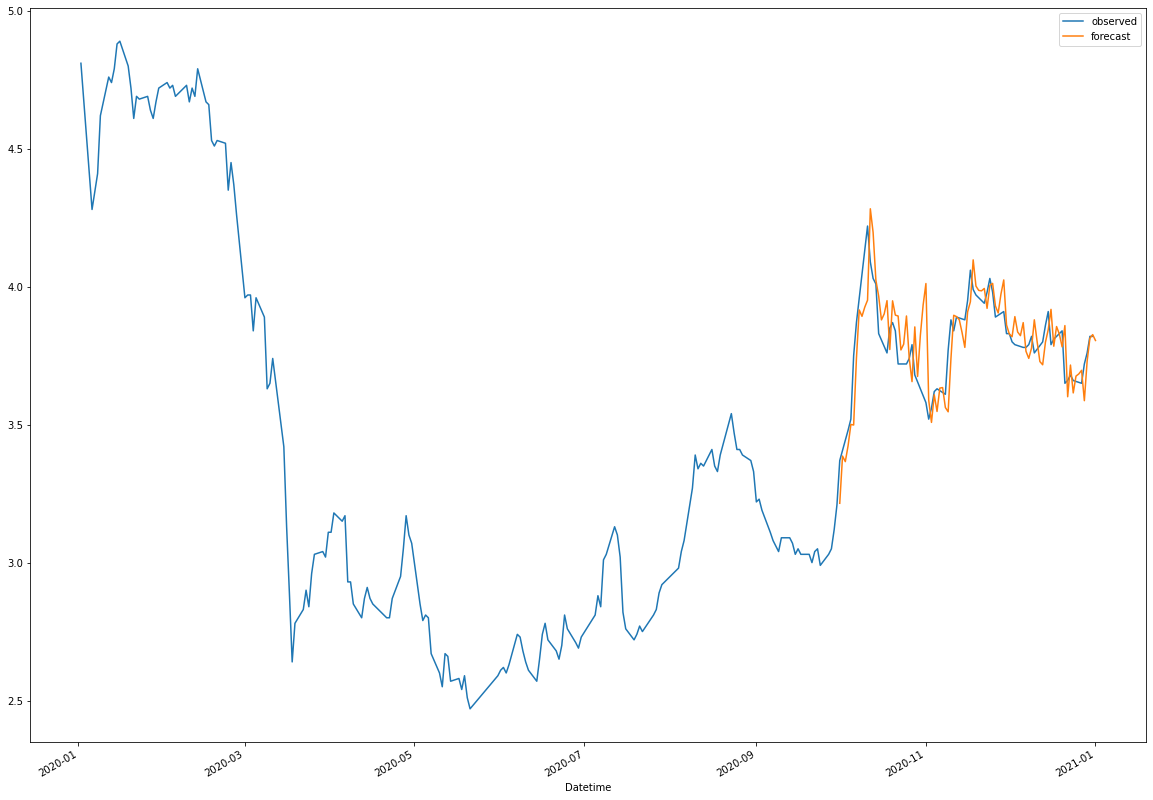

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2147.624, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2147.165, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2147.541, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2145.739, Time=0.01 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2148.957, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.218 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1071.870
Date:                Wed, 28 Dec 2022   AIC                           2145.739
Time:                        19:40:12   BIC                           2149.253
Sample:                             0   HQIC                          2147.154
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       332.3718     18.509     17.957      0.000     296.095 

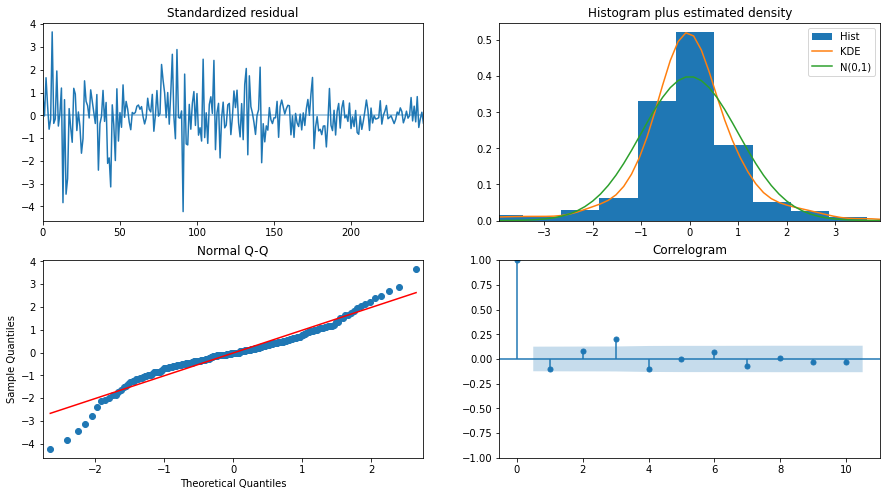

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38077D+00    |proj g|=  1.05528D-01

At iterate    5    f=  3.11061D+00    |proj g|=  1.60570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      8      9      1     0     0   1.346D-07   3.110D+00
  F =   3.1102476707520825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                      Price

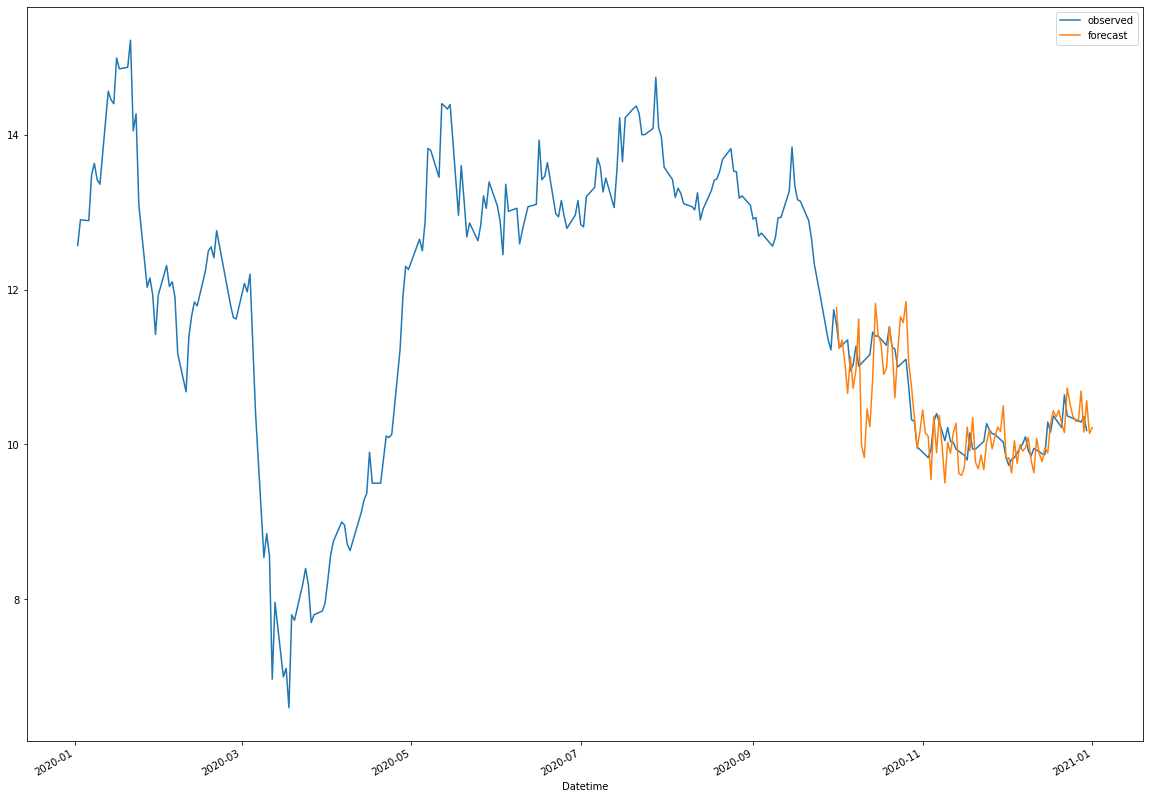

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2064.543, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2064.344, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2064.709, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2066.081, Time=0.02 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2062.505, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.314 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1034.040
Date:                Wed, 28 Dec 2022   AIC                          -2066.081
Time:                        19:40:14   BIC                          -2062.604
Sample:                             0   HQIC                         -2064.680
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.019e-05   5.51e-07     18.510      0.000    9.11e-06

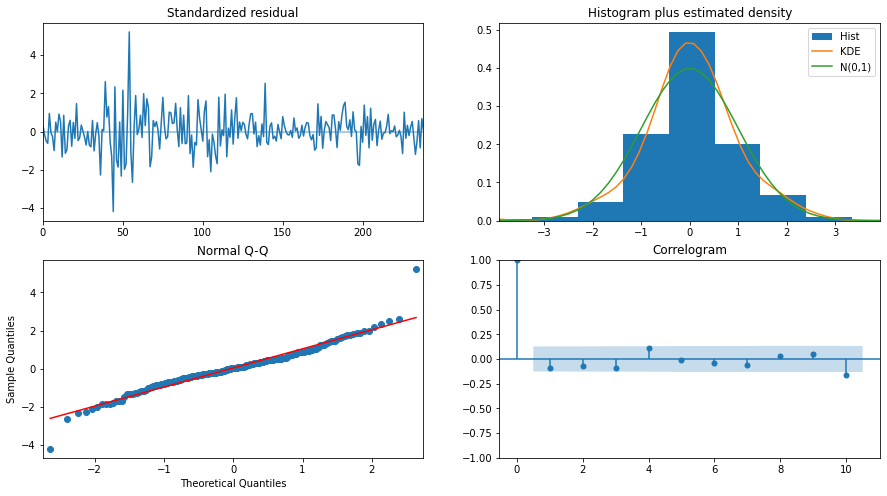

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.02707D+00    |proj g|=  7.56749D+02

At iterate    5    f= -2.38180D+00    |proj g|=  4.48234D-01
  ys=-2.508E-10  -gs= 5.286E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7     63      2     1     0   4.695D-01  -2.382D+00
  F =  -2.3817966643756527     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                                     SARIMAX Results                            

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


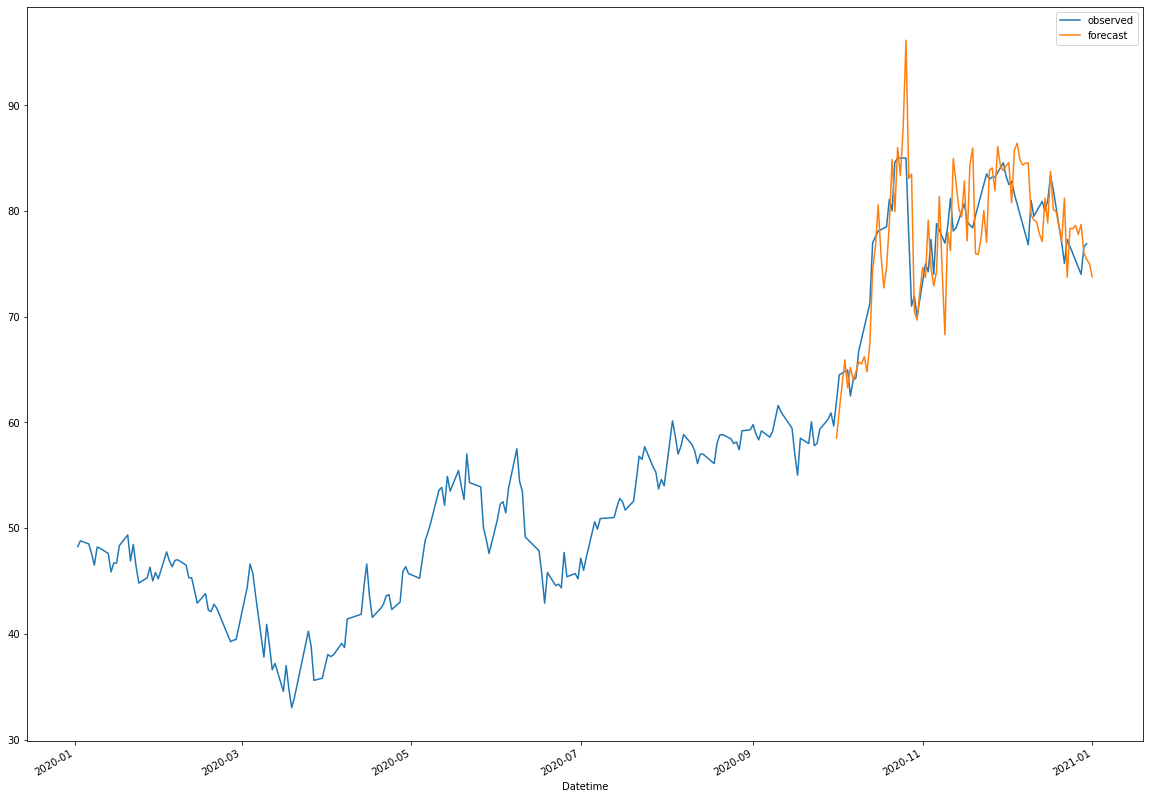

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1785.411, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1786.864, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1785.907, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1787.375, Time=0.02 sec


/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1786.868, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  242
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 894.687
Date:                Wed, 28 Dec 2022   AIC                          -1787.375
Time:                        19:40:15   BIC                          -1783.890
Sample:                             0   HQIC                         -1785.971
                                - 242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.491e-05   1.09e-06     32.021      0.000    3.28e-05

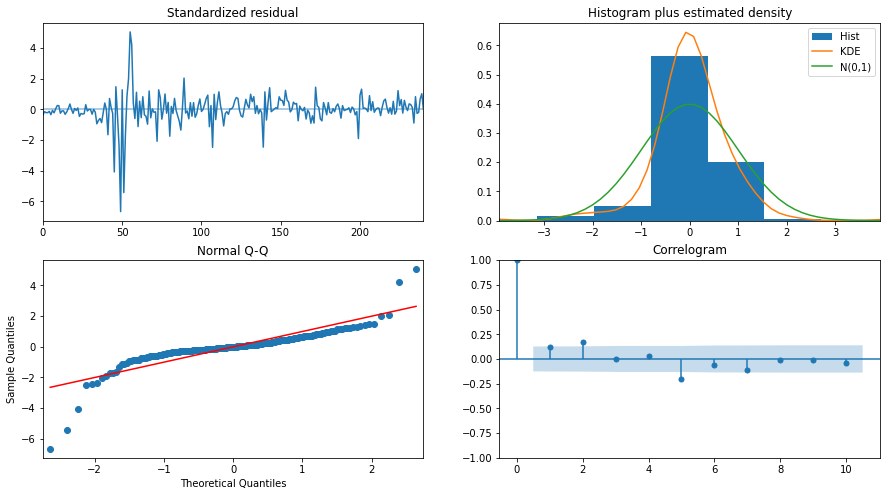

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.39788D+00    |proj g|=  6.12338D+02

At iterate    5    f= -1.96382D+00    |proj g|=  6.11142D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      8     22      1     0     0   2.579D-03  -1.964D+00
  F =  -1.9638217061408763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                      Price

 This problem is unconstrained.


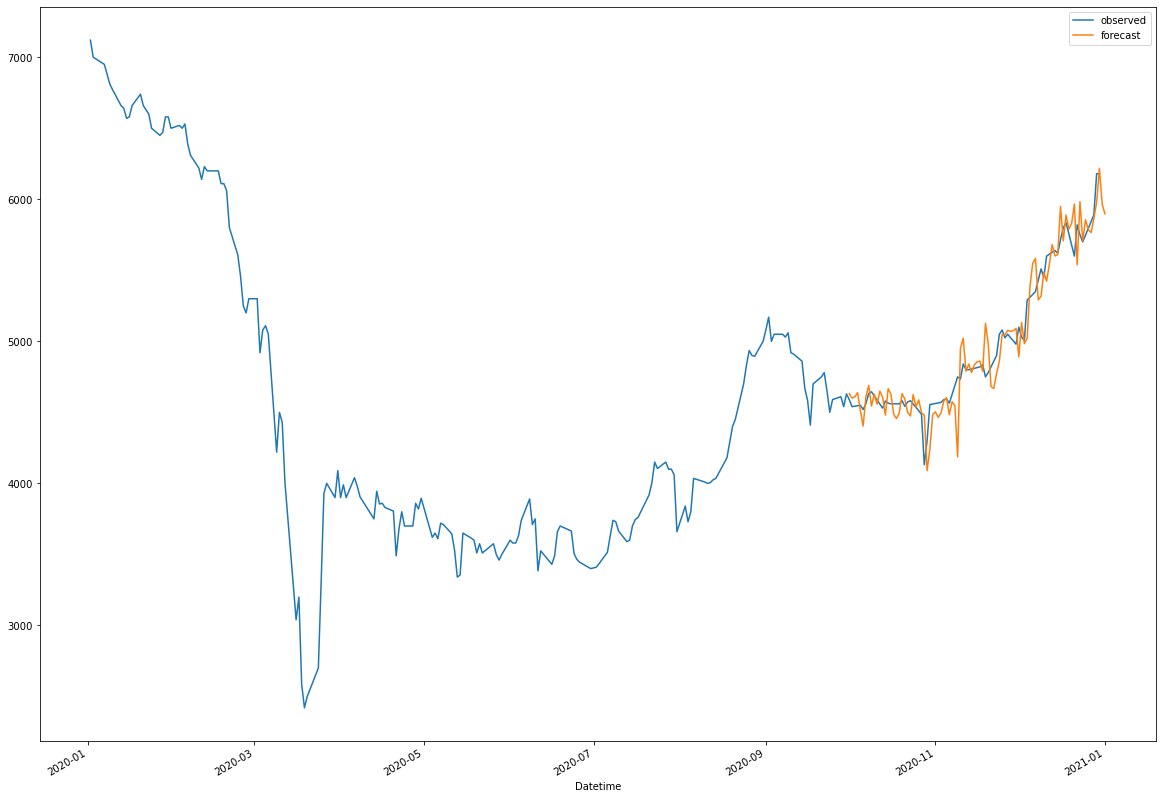

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7856.229, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7858.215, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7858.216, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7854.698, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7860.211, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.142 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3926.349
Date:                Wed, 28 Dec 2022   AIC                           7854.698
Time:                        19:40:15   BIC                           7858.224
Sample:                             0   HQIC                          7856.117
                                - 252                                       

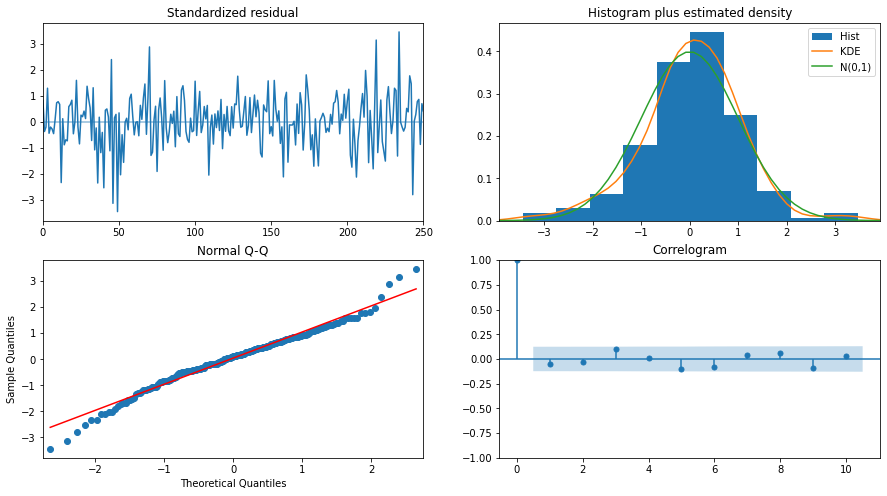

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09144D+01    |proj g|=  1.08802D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.088D-06   1.091D+01
  F =   10.914361451029860     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                      Price_box_cox   No. Observations:                  365
Model:      

 This problem is unconstrained.


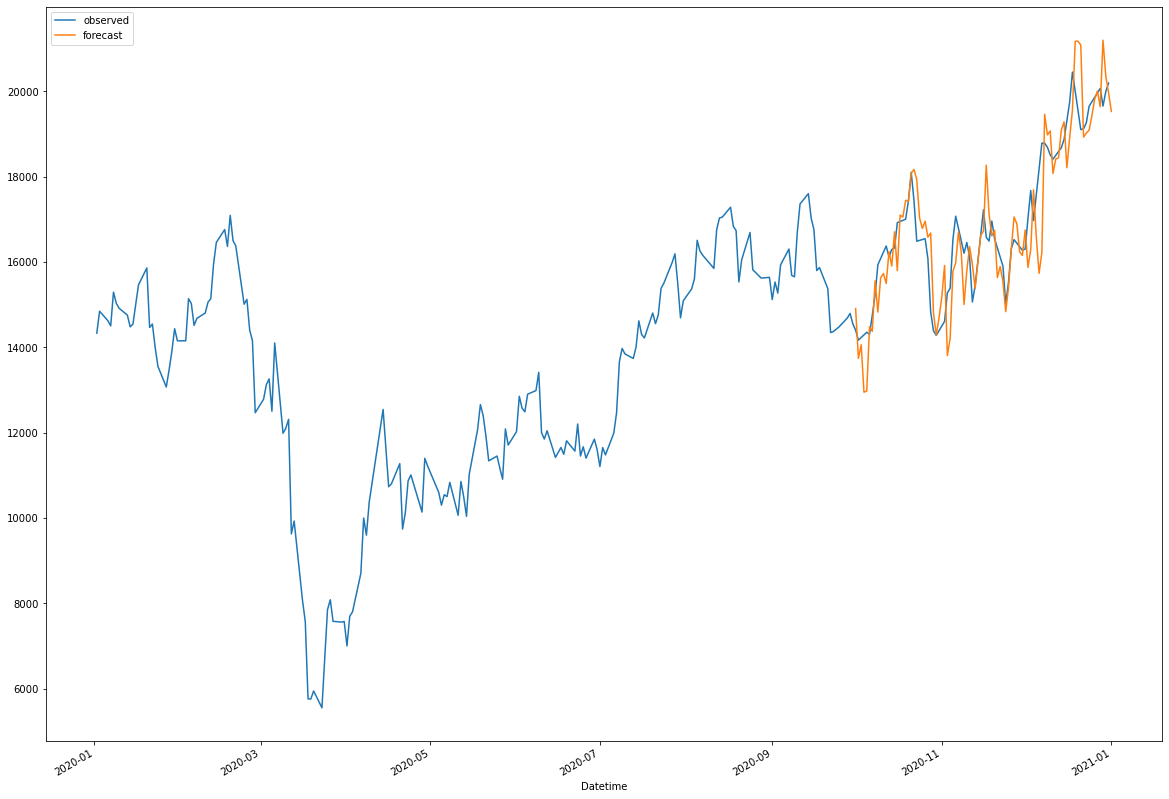

/var/folders/t7/d7p9g7d12w1fdy_jms911gtw0000gn/T/ipykernel_23081/1363633726.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4262.576, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4264.208, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4264.247, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4261.016, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4266.066, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.168 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  272
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2129.508
Date:                Wed, 28 Dec 2022   AIC                           4261.016
Time:                        19:40:16   BIC                           4264.618
Sample:                             0   HQIC                          4262.462
                                - 272                                       

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning:

invalid value encountered in reciprocal

/Users/shamil/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning:

invalid value encountered in reciprocal



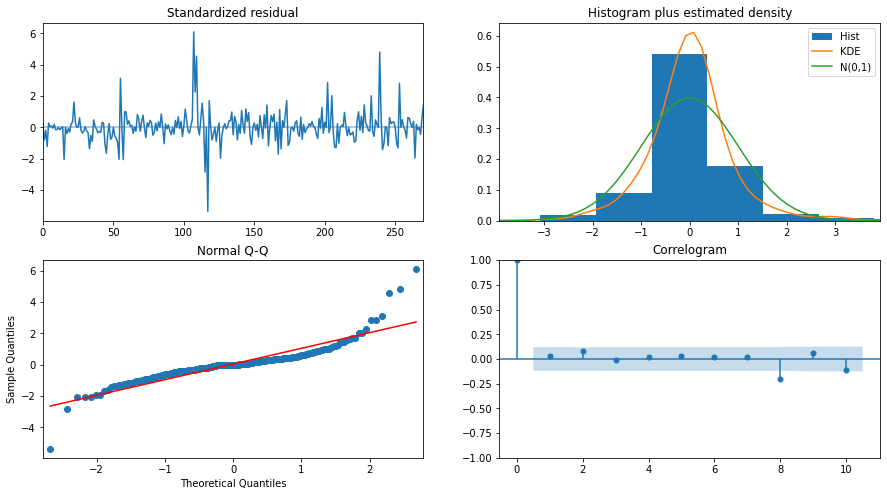

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16279D+00    |proj g|=  1.09454D-03

At iterate    5    f=  6.06161D+00    |proj g|=  5.07914D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5      8      1     0     0   5.079D-06   6.062D+00
  F =   6.0616091228016025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                      Price

 This problem is unconstrained.


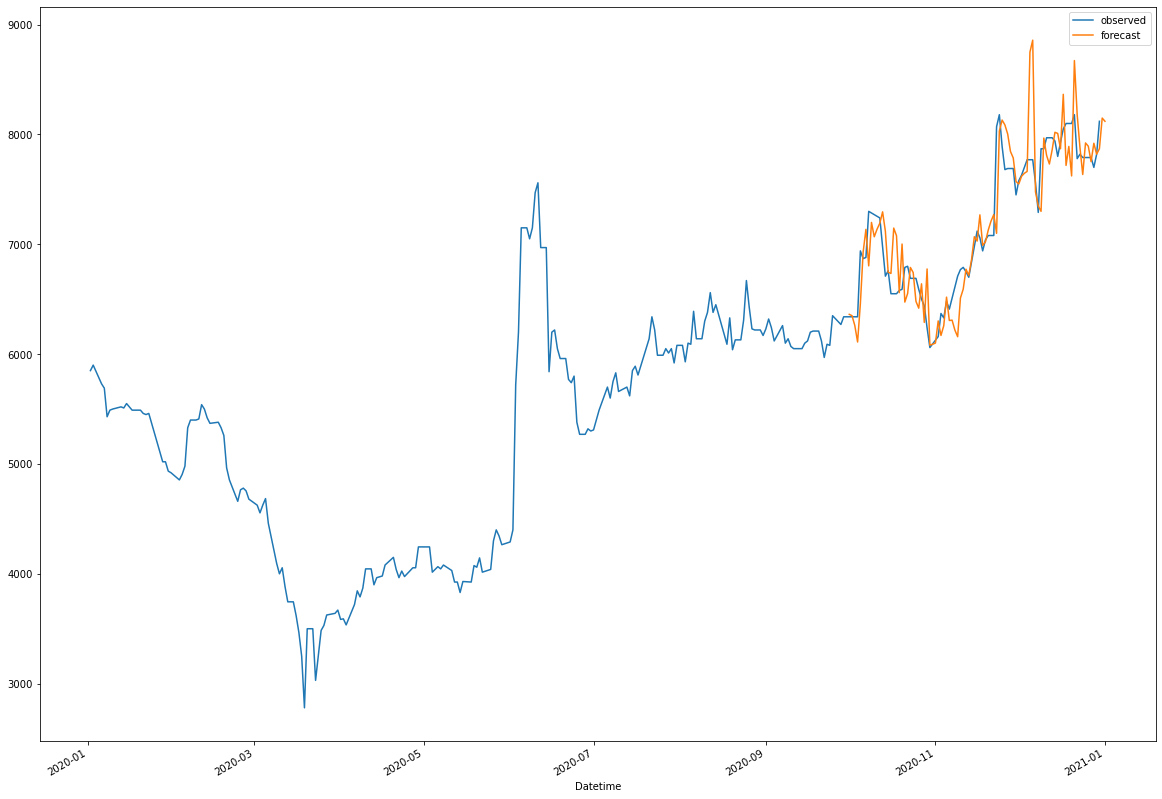

In [ ]:
i = 0
for sheet in sheets:
    # Set training data to be all data in 2021
    train_data = sheet[sheet["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")]

    # Apply box cox transformation
    train_data['Price_box_cox'], lam = boxcox(train_data['Price'].astype(float))

    # Plot the transformation
    fig = px.line(train_data, x='Datetime', y="Price_box_cox", title=list(df.keys())[i])
    fig.show()
    
    # Use Auto ARIMA to find the best p, d, and q values
    model_autoARIMA = auto_arima(train_data["Price_box_cox"], start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    print(model_autoARIMA.summary())

    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()

    # Create model
    model = sm.tsa.statespace.SARIMAX(train_data.resample("D").last()["Price_box_cox"], order=model_autoARIMA.order, seasonal_order=model_autoARIMA.order+(12,))
    fitted = model.fit()
    print(fitted.summary())

    # Create forecast
    predicted = fitted.get_prediction(start=pd.to_datetime("2020-10-01"), end=pd.to_datetime("2021-01-01"), dynamic=False, full_results=True)
    predicted_ci = fitted.conf_int()
    
    ax = (train_data[train_data["Datetime"] < datetime.strptime("2021-01-01", "%Y-%m-%d")].Price).plot(label='observed', figsize=(20, 15))
    inv_boxcox(predicted.predicted_mean, lam).plot(ax=ax, label='forecast')
    plt.legend()
    plt.show()

    i += 1

### Summary